[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/machinelearnear/large-scale-object-detection-with-sahi/blob/main/SAHI_inference.ipynb)

# Detecting Twenty-thousand Classes using Image-level Supervision

<img align="center" src="https://github.com/facebookresearch/Detic/raw/main/docs/teaser.jpeg" width="800">

This is a colab demo of using Detic (A **Det**ector with **i**mage **c**lasses). We will use the pretrained Detic models to run object detection on both the detector's vocabulary and any user-specifid vocabulary.

This demo is modified from the [detectron2 colab tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


## Pre-requisites

### Install `Detectron2`

In [3]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

torch:  1.10 ; cuda:  cu102
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html
     |████████████████████████████████| 6.6 MB 558 kB/s            
  Using cached black-21.4b2-py3-none-any.whl (130 kB)
  Using cached pycocotools-2.0.4-cp38-cp38-linux_x86_64.whl
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Using cached cloudpickle-2.0.0-py3-none-any.whl (25 kB)
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
     |████████████████████████████████| 829 kB 4.2 MB/s            
  Preparing metadata (setup.py) ... done
  Using cached omegaconf-2.1.1-py3-none-any.whl (74 kB)
  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached iopath-0.1.9-py3-none-any.whl (27 kB)
  Using cached hydra_core-1.1.1-py3-none-any.whl (145 kB)
  Using cached fvcore-0.1.5.post20211023-py3-none-any.whl
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached toml-0.10.2-py2.py3-

### Clone and install `Detic`

In [4]:
# clone and install Detic
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
%cd Detic
# !pip install -r requirements.txt

fatal: destination path 'Detic' already exists and is not an empty directory.
/home/studio-lab-user/detic-detecting-20k-classes-using-image-level-supervision/Detic


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [6]:
# Detic libraries
sys.path.insert(0, 'third_party/CenterNet2/projects/CenterNet2/')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

In [7]:
# Build the detector and download our pretrained weights
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True # For better visualization purpose. Set to False for all classes.
# cfg.MODEL.DEVICE = "cpu" # run with cpu instead of CUDA
predictor = DefaultPredictor(cfg)

/home/studio-lab-user/.conda/envs/machinelearnear-detic/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
# Setup the model's vocabulary using build-in datasets

BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

vocabulary = 'lvis' # change to 'lvis', 'objects365', 'openimages', or 'coco'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


In [14]:
from PIL import Image

--2022-01-11 21:56:12--  https://web.eecs.umich.edu/~fouhey/fun/desk/desk.jpg
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289506 (283K) [image/jpeg]
Saving to: 'desk.jpg.5'

desk.jpg.5          100%[===================>] 282.72K  --.-KB/s    in 0.1s    

2022-01-11 21:56:12 (2.85 MB/s) - 'desk.jpg.5' saved [289506/289506]



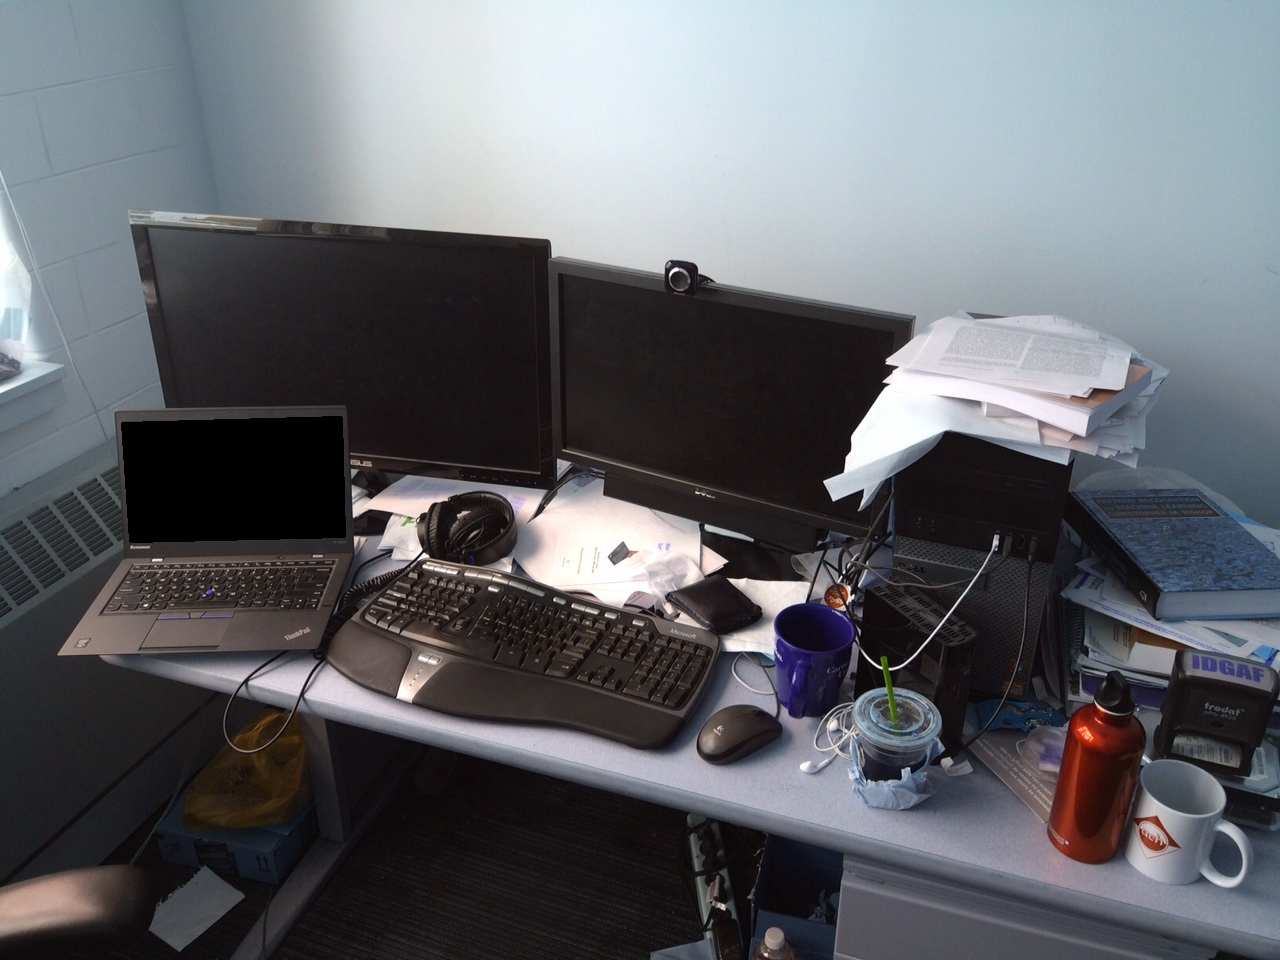

In [15]:
# Download a sample image and display. Replace path here to try your own images!
!wget https://web.eecs.umich.edu/~fouhey/fun/desk/desk.jpg
im = cv2.imread("./desk.jpg")
Image.fromarray(im)

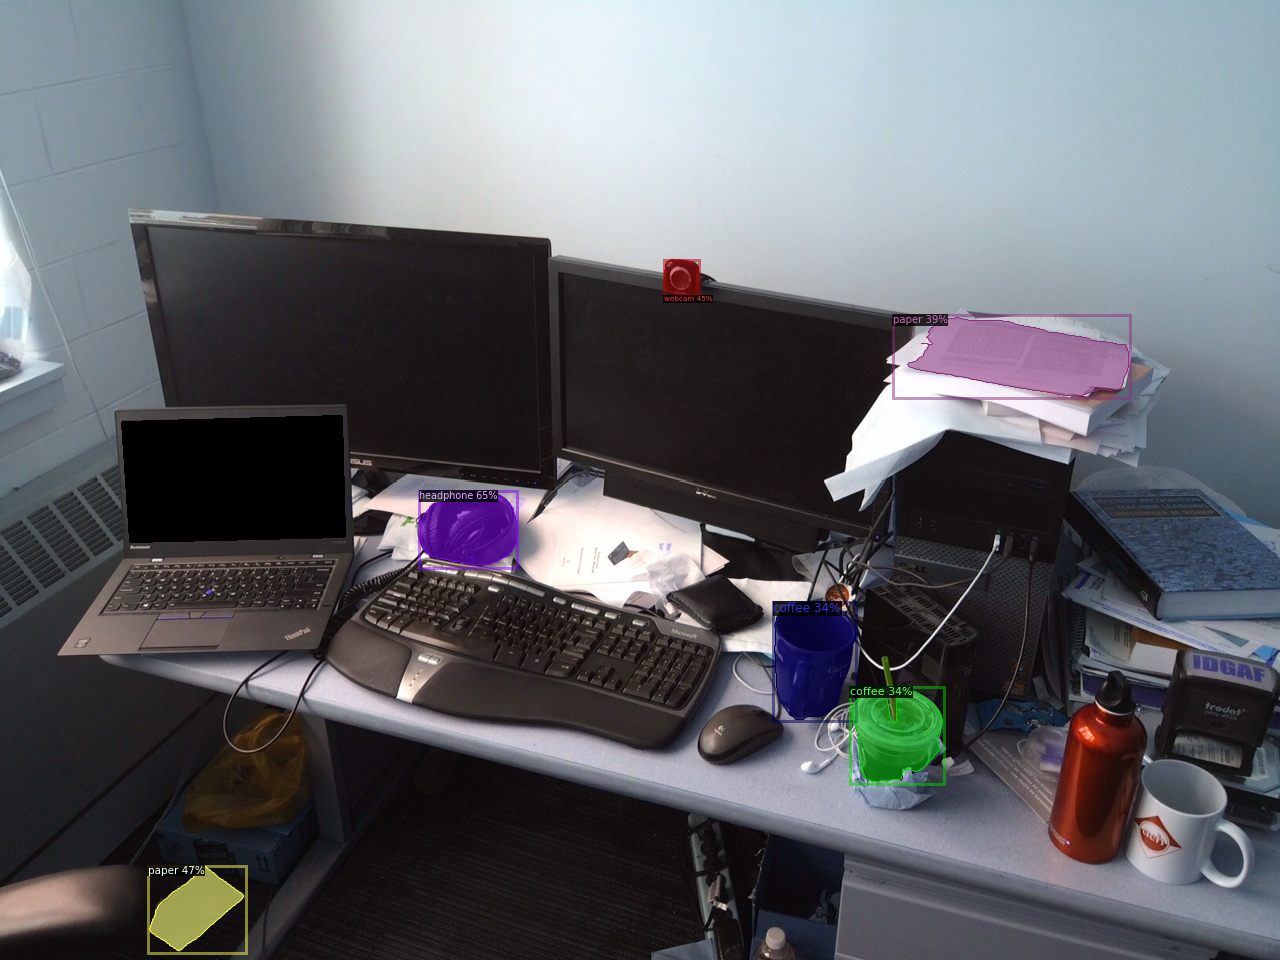

In [16]:
# Run model and show results
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
Image.fromarray(out.get_image()[:, :, ::-1])

In [19]:
metadata

namespace(name='__unused',
          thing_classes=['headphone', 'webcam', 'paper', 'coffee'])

In [20]:
# Change the model's vocabulary to a customized one and get their word-embedding 
#  using a pre-trained CLIP model.

from detic.modeling.text.text_encoder import build_text_encoder
def get_clip_embeddings(vocabulary, prompt='a '):
    text_encoder = build_text_encoder(pretrain=True)
    text_encoder.eval()
    texts = [prompt + x for x in vocabulary]
    emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
    return emb

In [75]:
vocabulary = 'custom'

for x in MetadataCatalog.keys(): 
    if x == '__test': MetadataCatalog.pop('__test')
metadata = MetadataCatalog.get("__test")
metadata.thing_classes = ['keyboard', 'mouse', 'wallet', 'coffee'] # # Change here to try your own vocabularies!
classifier = get_clip_embeddings(metadata.thing_classes)
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)
# Reset visualization threshold
output_score_threshold = 0.3
for cascade_stages in range(len(predictor.model.roi_heads.box_predictor)):
    predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

Loading pretrained CLIP


/home/studio-lab-user/.conda/envs/machinelearnear-detic/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


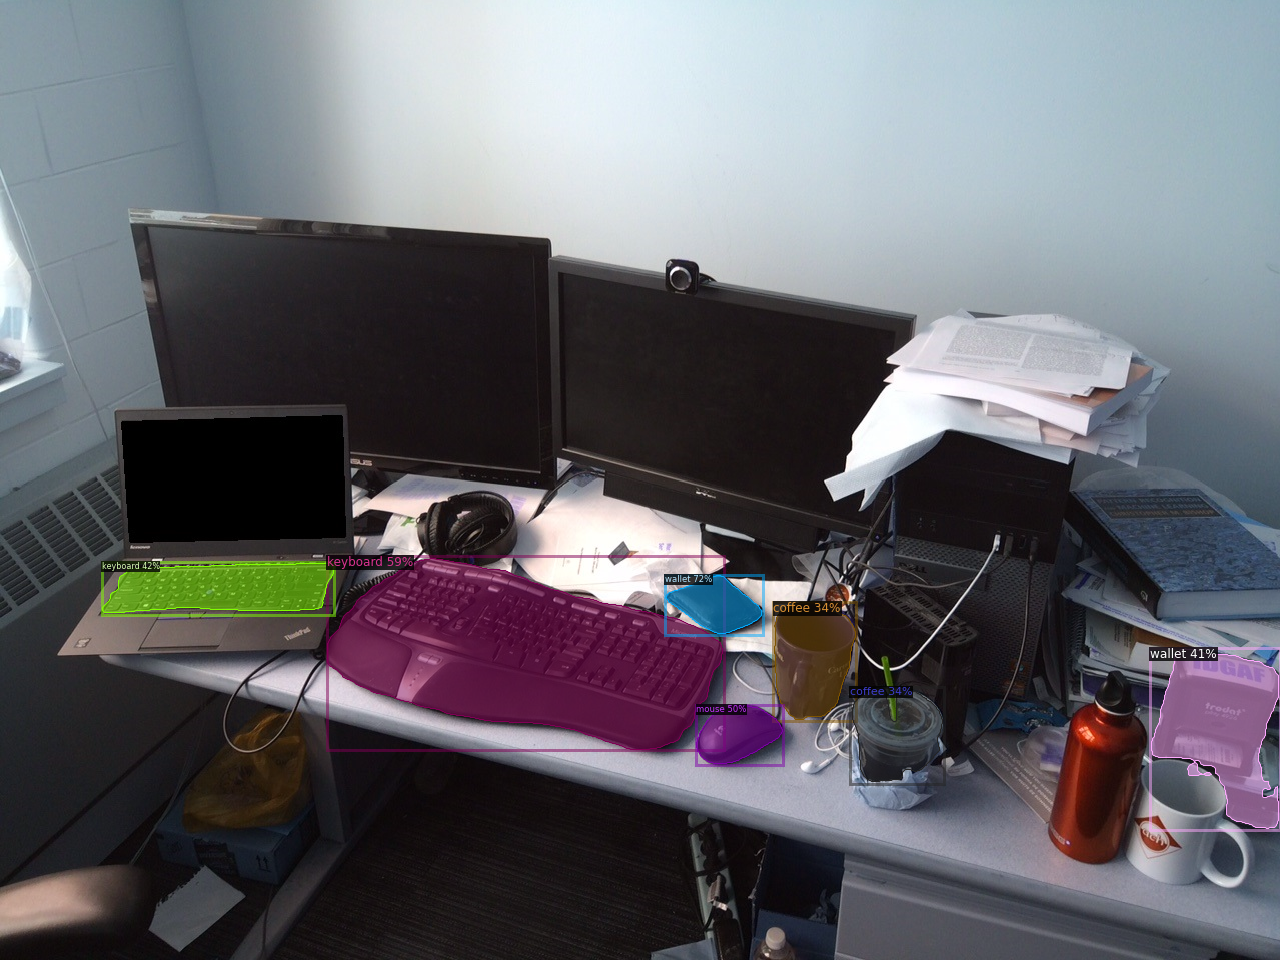

In [76]:
# Run model and show results
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
Image.fromarray(out.get_image()[:, :, ::-1])